# COLETA E PREPARAÇÃO DE DADOS

Esse **Jupyter Notebook** consiste na criação de um [Web Scrapping](https://pt.wikipedia.org/wiki/Coleta_de_dados_web) capaz de capturar letras de músicas na internet e criar uma análise básica sobre as letras. O Web Scrapping é feito utilizando o site [Vagalume](https://www.vagalume.com.br) e é capaz de capturar tanto a letra da musica original, quanto a letra traduzida.

## Importando as bibilotecas

Nessa fase do projeto é importado as bibliotecas utilizadas ao longo do desenvolvimento do Web Scrapping. Dentre as bibliotecas utilizadas, o destaque fica para a biblioteca [NLTK](https://www.nltk.org/), que é utilizada para obtenção das stopwords (preposições e palavras irrelevantes para esse projeto).

Para instalar as libs utilizadas nesse projeto, basta executar o comando **pip install -r requirements.txt** na pasta em que se encontra o arquivo **requirements.txt**. Caso esteja utilizando o [Anaconda](https://www.anaconda.com/) e queira criar um ambiente novo com todas as bibliotecas utilizadas nesse projeto, basta utlizar o comando **conda env create --name nome_do_seu_novo_ambiente --file=environments.yml**

In [1]:
from IPython.display import display
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import pandas as pd
import ssl
import re
from datetime import datetime

## Configurando o Web Scrapping

Para que o Web Scrapping funcione de forma correta, os links das músicas deverão ser do site [Vagalume](https://www.vagalume.com.br). Além disso, ao longo do desenvolvimento desse trabalho foi constatado que o site Vagalume possui vários tipos de versões e layouts de páginas. As páginas de músicas que fornecem a tradução diretamente no arquivo HTML da página são as páginas ideias para serem utilizadas nesse projeto. As páginas que possuem tradução dinâmica não funcionam nesse Web Scrapping.

In [2]:
# URL das músicas
MUSICS = {"musica_1": "https://www.vagalume.com.br/eminem/cleanin-out-my-closet-traducao.html",
          "musica_2": "https://www.vagalume.com.br/eminem/mockingbird-traducao.html",
          "musica_3": "https://www.vagalume.com.br/eminem/lose-yourselftraducao.html"}

# Obter a versão original ou a tradução, se disponível
ORIGINAL_VERSION = True

## Criando as funções

As funções que são utilizadas ao longo do projeto são criadas logo abaixo. Cada função cumpre o seu propósito, que vai desde a obtenção da página em HTML até a contagem de ocorrências de palavras nas letras das músicas.

In [3]:
def get_html_pages(musics: dict):
    """Obtém o HTML da página."""
    html_musics = {}
    try:
        for music, url in musics.items():
            html = urlopen(url, context=ssl._create_unverified_context())
            bs = BeautifulSoup(html.read(), "html.parser")
            html_musics[music] = bs
        return html_musics
    except (Exception, HTTPError) as e:
        return f"Ocorreu o seguinte erro: {e}"
    

def get_lyrics(html_musics: dict, original_version: bool):
    """Obtém a letra da música."""
    class_to_find = "orig" if original_version else "trad"
    lyrics = {}    
    for music, lyric in html_musics.items():        
        lyric = [x.get_text() for x in lyric.find_all("div", {"class": class_to_find})]         
        lyrics[lyric[0]] = lyric[1:]
    return clear_lyrics(lyrics)


def clear_lyrics(lyrics: dict):
    """Aplica a limpeza de dados na letra da música."""
    cleard_music = {}
    for music, lyric in lyrics.items():
        lyric = [re.sub(r"[,\"?]+", "", x) for x in lyric if len(x) > 0]  
        cleard_music[music] = lyric
    return cleard_music


def get_words_from_lyrics(lyrics: dict, original_version: bool):
    """Obtém as palavras da letra da música."""
    music_words = {}
    for music, lyric in lyrics.items():
        words = []
        for line in lyric:
            for word in line.split(" "):
                words.append(word.lower())
        music_words[music] = words
    return remove_stopwords(music_words, original_version)


def remove_stopwords(music_words: dict, original_version: bool): 
    """Remove as palavras consideradas irrelevantes e preposições."""
    language = "english" if original_version else "portuguese"
    nltk.download("stopwords", quiet=True)
    lyric_without_stopwords = {}
    for music, words in music_words.items():
        lyric_without_stopwords[music] = [x for x in words if x not in stopwords.words(language)]        
    return lyric_without_stopwords


def count_words_occurrences(music_lyrics_word: dict, reverse_order: bool = True):
    """Faz a contagem da ocorrência de palavras na letra da música."""
    occurrences = {}  
    # Faz a contagem da ocorrência de cada palavra dentro de cada música
    for music, words in music_lyrics_word.items():
        occurrences[music] = {}
        for word in words:
            if word not in occurrences[music]:
                occurrences[music][word] = 1
            else:
                occurrences[music][word] += 1  
                
    # Ordena os dicionários
    for key, values in occurrences.items():
        occurrences[key] = sorted(values.items(), key=lambda x: x[1], reverse=reverse_order)
        
    # Transforma o dicionário para o formato esperado    
    new_dict = {}
    for music, words in occurrences.items():
        new_dict[music] = {}
        for key, value in words:
            new_dict[music][key] = value
    return new_dict

def show_histogram(music, music_name):
    # Obtendo os dados das 50 palavras mais utilizadas nas músicas
    keys = list(music.keys())[:50]
    values = list(music.values())[:50]
    
    # Configurando o eixo Y para ter escala equivalente a quantidade de palavras
    y_pos = list(range(len(keys)))
    
    # Configurando o histograma
    fig, ax = plt.subplots(figsize=(20, 15))

    ax.barh(y_pos, values, align='center')
    ax.set_yticks(y_pos, labels=keys)
    ax.invert_yaxis()  
    ax.set_xlabel("Quantidade")
    ax.set_title(f"Música: {music_name}")

    # Exibindo o histograma
    plt.show()

## Iniciando a captura dos dados

Essa é a fase que ocorre a captura da página HTML e a obtenção da letra das músicas.

In [4]:
# Obtém a página HTML da música
html_musics = get_html_pages(MUSICS)

# Obtém a letra da música da página
lyrics = get_lyrics(html_musics, ORIGINAL_VERSION)

A letra de cada música capturada pelo Web Scrapping é exibida na célula seguinte:

In [5]:
# Exibe a letra da primeira música capturada
for music, lyric in lyrics.items():  
    print("*" * 50)
    print(f"Música: {music}")
    print("*" * 50)
    for line in lyric:
        print(line)
    print("\n")

**************************************************
Música: Cleanin' Out My Closet
**************************************************
Where's my snare
I have no snare on my headphones
There you go yeah yo yo
Have you ever been hated or discriminated against
I have I've been protested and demonstrated against
Picket signs for my wicked rhymes look at the times
Sick as the mind of the motherfucking kid that's behind
All this commotion emotions run deep as oceans explodin'
Tempers flarin' from parents just blow 'em off and keep goin'
Not takin' nothin' from no one give 'em hell long as I'm breathin'
Keep kickin' ass in the mornin' and takin' names in the evenin'
Leaving with a taste as sour as vinegar in their mouth
See they can trigger me but they'll never figure me out
Look at me now I betcha probably sick of me now
Ain't you mama I 'ma make you look so ridiculous now
I'm sorry mama I never meant to hurt you
I never meant to make you cry
But tonight I'm cleanin' out my closet
One more ti

## Feature Engineering

O tratamento dos dados ocorre nesse passo. O objetivo é trabalhar no tratamento de dados de cada música individualmente. No final, os dados devem estar contidos dentro de um dicionário no formato: 

**{nome_musica_1: {palavra_1: quantidade_1,..., palavra_n: quantidade_n},
  {...},
  {nome_musica_n: {palavra_1: quantidade_1,..., palavra_n: quantidade_n}}**
  
Com os dados organizados em dicionários ficará mais fácil trabalhar com o passo de exibição a seguir.

In [6]:
# Obtém cada palavra da letra das músicas
music_lyrics_word = get_words_from_lyrics(lyrics, ORIGINAL_VERSION)

# Faz a contagem da ocorrência das palavras
words_dict = count_words_occurrences(music_lyrics_word)

## Criando e exibindo os Dataframes

Nessa fase do projeto é criado os Dataframes utilizando [Pandas](https://pandas.pydata.org/docs/index.html) e logo em seguida é exibido as 5 primeiras palavras mais utilizadas em cada música.

In [7]:
dataframes = []

# Obtendo o nome de todas as músicas
musics = list(words_dict.keys())

# Criando os Dataframes
for index, words in enumerate(words_dict.values()):
    df = pd.DataFrame(words_dict[musics[index]].items(), columns=["palavra", "contagem"])
    df.name = musics[index]
    dataframes.append(df)
    
# Exibindo as 5 primeiras palavras de cada Dataframe
for index, df in enumerate(dataframes):   
    print(f"Música: {df.name}")        
    display(df.head())

Música: Cleanin' Out My Closet


,palavra,contagem
0,i'm,16
1,never,15
2,meant,12
3,mama,9
4,make,8


Música: Mockingbird


,palavra,contagem
0,know,10
1,daddy,10
2,see,10
3,little,8
4,daddy's,8


Música: Lose Yourself


,palavra,contagem
0,better,16
1,go,12
2,one,10
3,he's,10
4,shot,9


## Exibindo os histogramas

Após a captura, limpeza e trabalhado realizado nos dados, é hora da exibição. O objetivo nesas fase do projeto é exibir um histograma que deixe claro, visualmente, quais foram as palavras mais utilizadas em cada música.

In [8]:
# Obtendo os dados das 3 primeiras músicas individualmente
musica_1 = words_dict[musics[0]]
musica_2 = words_dict[musics[1]]
musica_3 = words_dict[musics[2]]

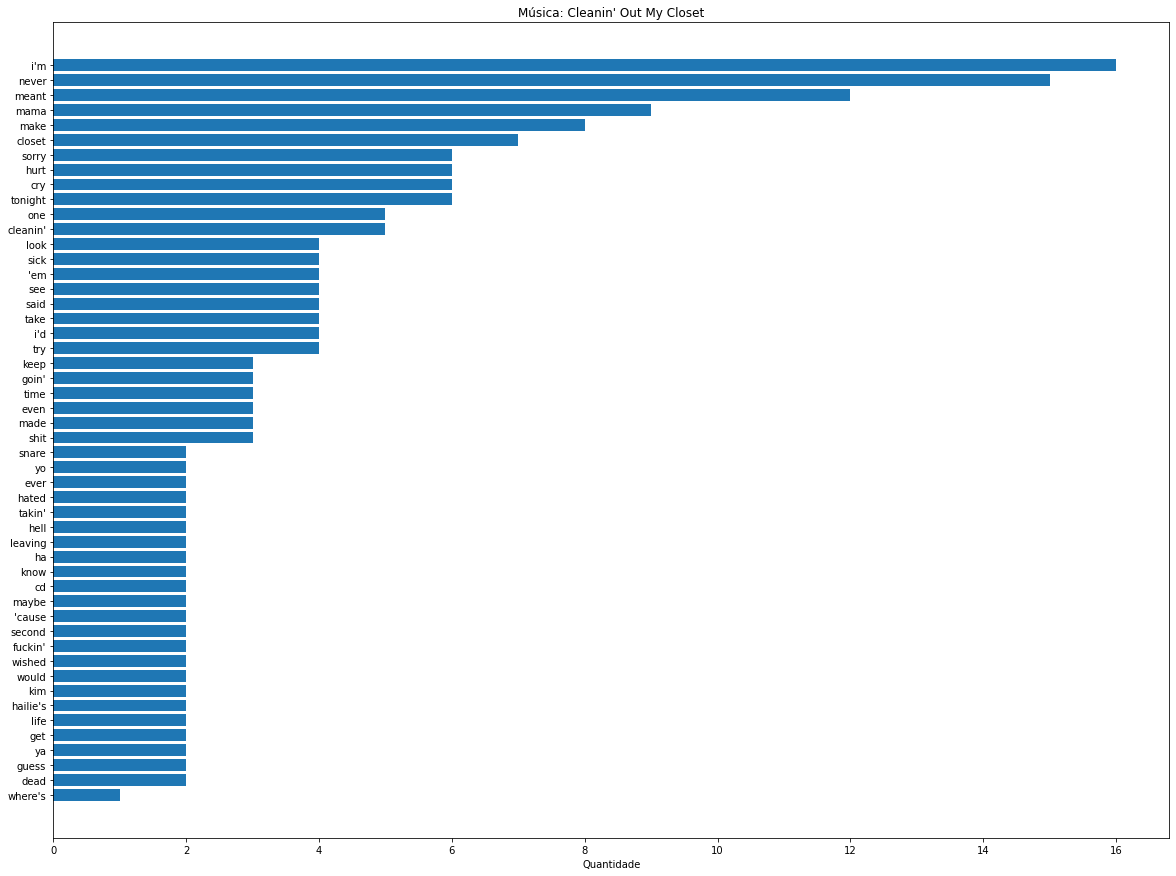

In [9]:
# Exibindo o histograma da primeira música
show_histogram(musica_1, musics[0])

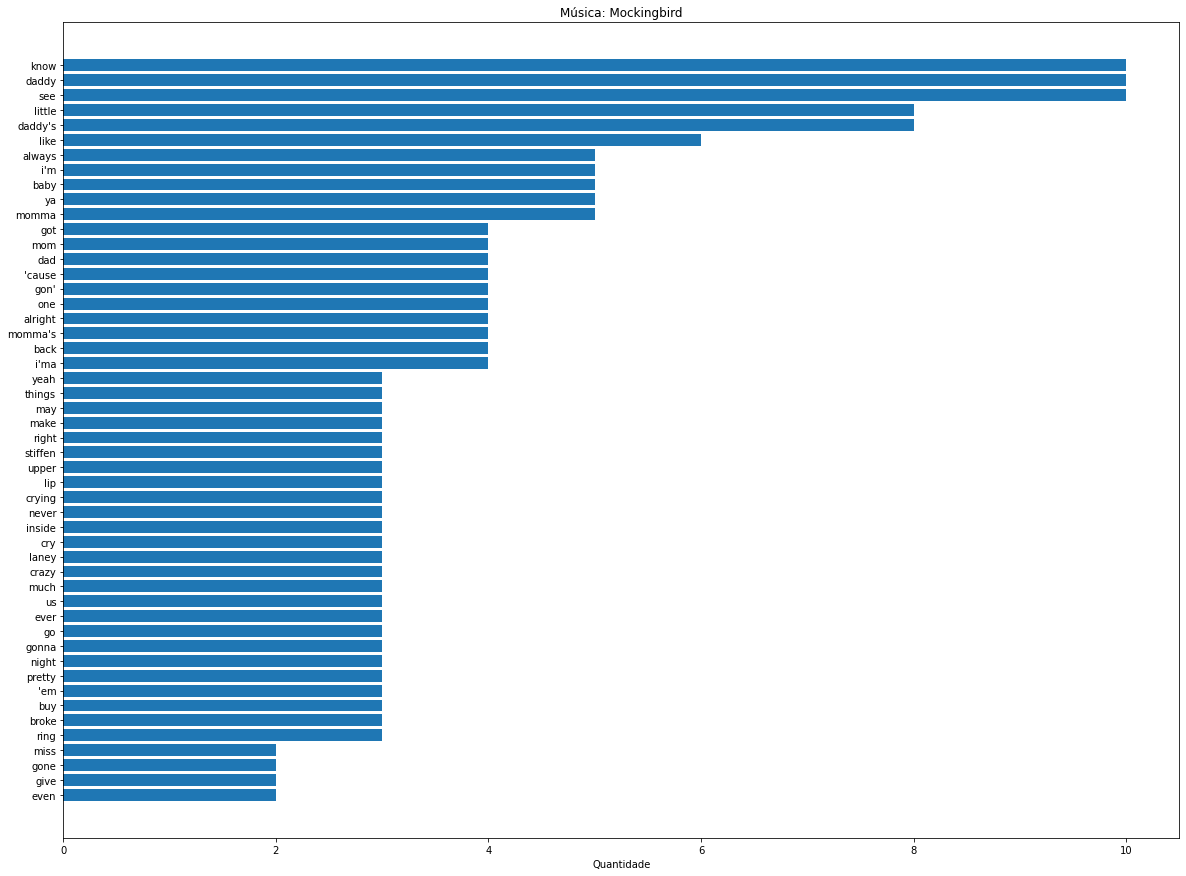

In [10]:
# Exibindo o histograma da segunda música
show_histogram(musica_2, musics[1])

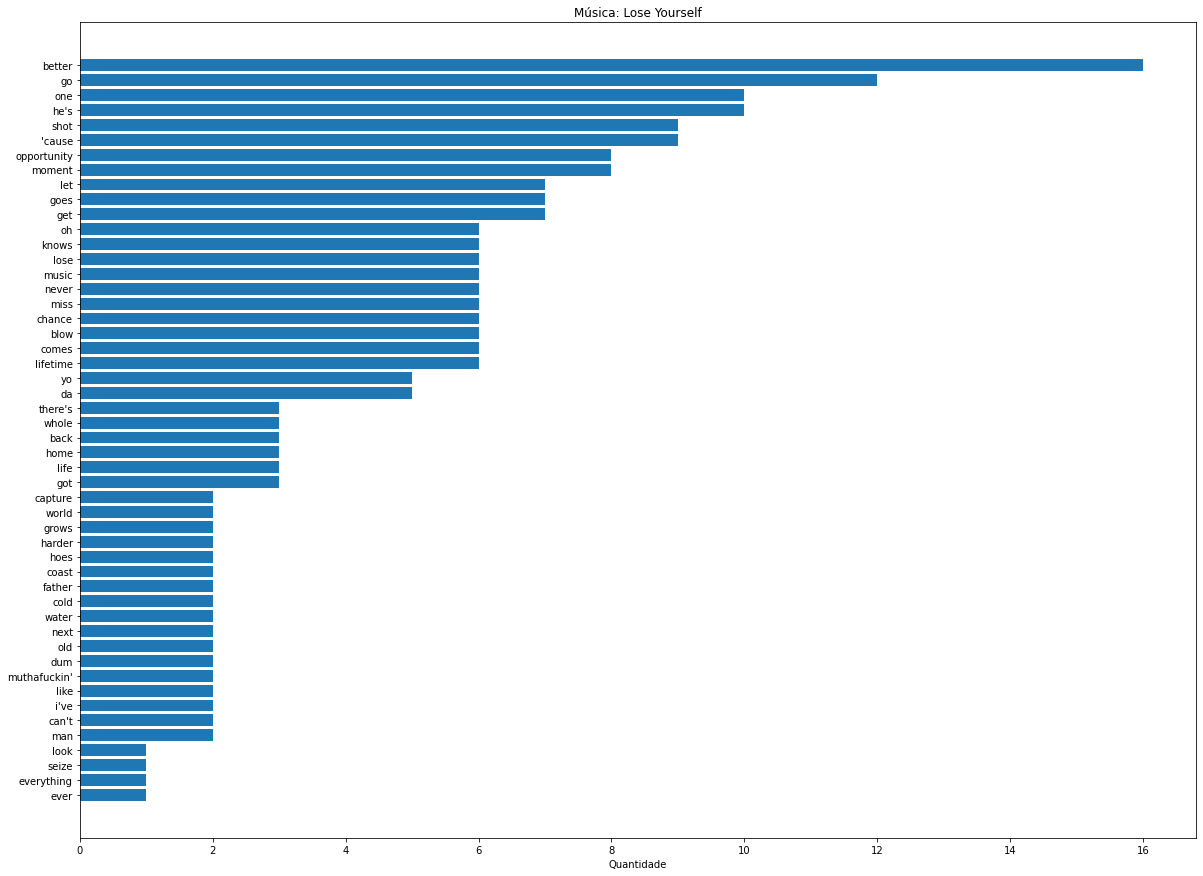

In [11]:
# Exibindo o histograma da terceira música
show_histogram(musica_3, musics[2])

## Exportando os dados para um arquivo csv

O objetivo nessa fase do projeto é exportar um arquivo CSV contendo informações no formato:

**data\hora;meu_nome;site;artista,musica;palavra;contagem**

In [12]:
# Informações
data_atual = datetime.today().strftime("%d-%m-%Y %H:%M:%S")
meu_nome = "wellington junior nora"
site = "vagalume"
artista = "eminem"

# Complementando os dados dos dataframes criados

for index, df in enumerate(dataframes):
    df["data_hora"] = data_atual
    df["meu_nome"] = meu_nome
    df["site"] = site
    df["artista"] = artista
    df["musica"] = musics[index].lower()    
    
    # Reordenando o dataframe
    df = df[["data_hora", "meu_nome", "site", "artista", "musica", "palavra", "contagem"]]
    
    # Atualizando o dataframe com somente as primeiras 50 palavras mais utilizadas de cada música
    dataframes[index] = df.loc[:50]
        
# Unindo os dataframes em um dataframe único
dataframe_to_export = pd.concat([x for x in dataframes])

# Exportando o dataframe
dataframe_to_export.to_csv("musicas.csv", sep=";", index=False)

Importando o arquivo CSV para ver o resultado final.

In [13]:
# Criando um Dataframe a partir do arquivo CSV
novo_df = pd.read_csv(filepath_or_buffer="musicas.csv", sep=";")

# Exibindo as 5 primeiras linhas do dataframe
display(novo_df.head())

# Exibindo as últimas 5 linhas do dataframe
display(novo_df.tail())

,data_hora,meu_nome,site,artista,musica,palavra,contagem
0,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,cleanin' out my closet,i'm,16
1,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,cleanin' out my closet,never,15
2,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,cleanin' out my closet,meant,12
3,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,cleanin' out my closet,mama,9
4,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,cleanin' out my closet,make,8


,data_hora,meu_nome,site,artista,musica,palavra,contagem
148,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,lose yourself,look,1
149,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,lose yourself,seize,1
150,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,lose yourself,everything,1
151,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,lose yourself,ever,1
152,28-02-2022 10:10:04,wellington junior nora,vagalume,eminem,lose yourself,wanted,1
